# Image classificaiton with SVM algorithms

In [1]:
import pandas as pd
import numpy as np
import os
%matplotlib inline 
import matplotlib.pyplot as plt


#load data

DATA_PATH = "/content/data/"

# this funciton unpickles data from file 
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# unpickle all data batches
batch1=unpickle(DATA_PATH+"data_batch_1")
batch2=unpickle(DATA_PATH+"data_batch_2")
batch3=unpickle(DATA_PATH+"data_batch_3")
batch4=unpickle(DATA_PATH+"data_batch_4")
batch5=unpickle(DATA_PATH+"data_batch_5")
test_batch=unpickle(DATA_PATH+"test_batch")

print(batch1)


{b'batch_label': b'training batch 1 of 5', b'labels': [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 

Loaded in this way, each of the batch files contains a dictionary with the following elements:

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In [2]:
# checking dataset size 
print(batch1[b'data'][1].size)
print(len(batch1[b'labels']))

3072
10000


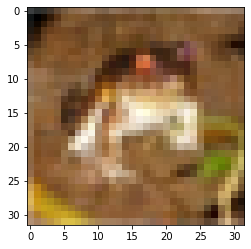

In [3]:
from skimage.transform import resize

images=[]
flat_images=[]
labels=[]

# this funciton reshapes the image data into (32,32,3) array 
def reshape_image(image):
  img_r=image[0:1024].reshape(32,32)
  img_g=image[1024:2048].reshape(32,32)
  img_b=image[2048:].reshape(32,32)
  img = np.dstack((img_r, img_g, img_b))
  return img

# reshape training dataset
for i in range(0,10000):
    image=batch1[b'data'][i, :]
    reshaped_img = reshape_image(image)
    images.append(reshaped_img)
    flat_images.append(reshaped_img.flatten())

plt.imshow(images[0],interpolation='nearest')


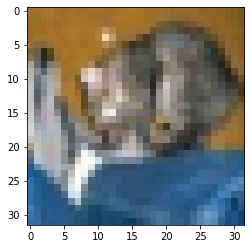

In [4]:
# reshape test dataset 
test_images=[]
flat_test_images=[]
for i in range(0,10000):
    image=test_batch[b'data'][i, :]
    img = reshape_image(image)
    test_images.append(img)
    flat_test_images.append(img.flatten())

plt.imshow(test_images[0],interpolation='nearest')

In [5]:
# prepare training set and testing set 
x_train=flat_images[0:300] # only using the first 300 samples from batch 1 to reduce the speed for testing purpose 
print("x_train: ")
print(x_train)
print("\n")

labels=np.array(batch1[b'labels'])
y_train=labels[0:300]
print("y_train: ")
print(y_train)
print("\n")

test_labels=np.array(test_batch[b'labels'])

x_test=flat_test_images[0:300]
print("x_test: ")
print(x_test)
print("\n")

labels=np.array(test_batch[b'labels'])
y_test=test_labels[0:300]
print("y_test: ")
print(y_test)

x_train: 
[array([ 59,  62,  63, ..., 123,  92,  72], dtype=uint8), array([154, 177, 187, ..., 143, 133, 144], dtype=uint8), array([255, 255, 255, ...,  80,  86,  84], dtype=uint8), array([28, 25, 10, ..., 72, 65, 46], dtype=uint8), array([170, 180, 198, ...,  73,  77,  80], dtype=uint8), array([159, 102, 101, ..., 182,  57,  19], dtype=uint8), array([164, 206,  84, ..., 122, 170,  44], dtype=uint8), array([ 28,  35,  39, ..., 101, 140,  96], dtype=uint8), array([134, 186, 223, ...,  32,  94, 138], dtype=uint8), array([125, 125, 116, ..., 144, 116,  86], dtype=uint8), array([53, 65, 53, ..., 49, 50, 41], dtype=uint8), array([142, 149, 152, ..., 163, 125, 111], dtype=uint8), array([164, 215, 244, ..., 120, 154, 100], dtype=uint8), array([17,  3,  2, ..., 32, 23, 16], dtype=uint8), array([100, 146, 192, ..., 156, 150, 137], dtype=uint8), array([100, 168, 231, ..., 162, 185, 202], dtype=uint8), array([235, 236, 238, ...,  51,  68,  14], dtype=uint8), array([110, 104,  97, ...,  51,  48,  

Goal of SVM:
1. Increase the distance of decision boundary to classes (or support vectors)
2. Maximize the number of points that are correctly classified in the training set

hyperparameters:

C - adds penalty for each misclassified data

Gamma - used for non-linear kernel to control the similarity radius. Very large gamma may cause overfit  

Kernel selection:

linear is not suitable for this task for being over simplified. Sigmoid kernel is suitable for binary classification. Therefore, we only try Gaussian and polynomial kernel



In [6]:
# the basic svm
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

svc=svm.SVC() 
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
model=GridSearchCV(svc,param_grid)
model.fit(x_train,y_train)
pred = model.predict(x_test)
print("best parameters: ")
print(model.best_params_)
print("Accuracy score: ")
print(metrics.accuracy_score(y_test,pred))


best parameters: 
{'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Accuracy score: 
0.21


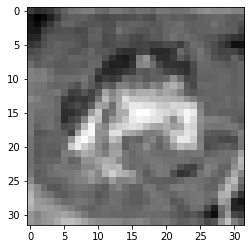

In [7]:
# basic feature extraction 
from sklearn.preprocessing import MinMaxScaler

# gray scale 
gray_images=[]
flat_gray_images=[]
gray_test_images=[]
rgb_weights = [0.2989, 0.5870, 0.1140]

# training set 
for image in images:
  grayscale= np.dot(image[...,:3],[0.2989, 0.5870, 0.1140])
  gray_images.append(grayscale)
  flat_gray_images.append(grayscale.flatten())

plt.imshow(gray_images[0], cmap=plt.get_cmap('gray'))

# testing set 
for image in test_images:
  grayscale_test= np.dot(image[...,:3],[0.2989, 0.5870, 0.1140])
  gray_test_images.append(grayscale.flatten())

# normalising the feature vectors 
scaler = MinMaxScaler(feature_range=(0, 1))
# normalising training set 
rescaled_gray_images = scaler.fit_transform(flat_gray_images)
# normalising testing set 
rescaled_testing_images = scaler.fit_transform(gray_test_images)

In [8]:
print(len(rescaled_gray_images))

10000


Extracting edges as features: 

Edges are sharp changes in colour in the images. There are various kernels that can be used to highlight the edges in an image. In this case we use Prewitt kernel 


In [9]:
# Advanced feature extraction - uncompleted !!
# Extracting Edge Features using prewitt kernel 

from skimage.filters import prewitt_h,prewitt_v

edges=[]
for image in gray_images:
  edges_prewitt_horizontal = prewitt_h(image)
  edges_prewitt_vertical = prewitt_v(image)
  edges.append(edges_prewitt_horizontal)
  

# need to use Histogram of Oriented Gradients (HOG) to further reduce 

Other advanced feature extractions:


Hough transform

Texture extraction

Thresholding


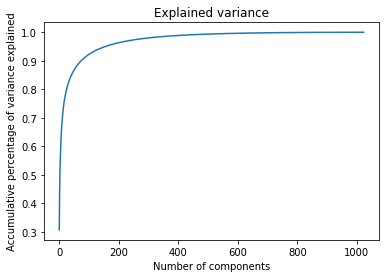

In [20]:
# feature reduction on extracted features using PCA

from sklearn.decomposition import PCA
pca = PCA()
images_pca=pca.fit_transform(rescaled_gray_images)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Accumulative percentage of variance explained')
plt.title('Explained variance')
plt.show()

In [23]:
pca = PCA(n_components=80)
x_train=pca.fit_transform(rescaled_gray_images)
x_train=x_train[0:300]
x_test=pca.fit_transform(rescaled_testing_images)

print("x_train: ")
print(x_train)
print("\n")

print("y_train: ")
print(y_train)
print("\n")

print(x_train.size)

x_train: 
[[-2.86287529 -1.83275034  1.52996573 ...  0.17117619 -0.39816379
   0.00978592]
 [ 0.07335412  0.57223495  3.50130069 ...  0.35744375 -0.18248322
   0.34272046]
 [ 4.22877001  6.8341114  -1.20003653 ... -0.07942271 -0.18353705
  -0.34743841]
 ...
 [-2.69306952 -2.05562961  0.48289529 ...  0.13394227 -0.39698474
   0.23571245]
 [-6.42269026 -2.41281005  1.633124   ...  0.05794653  0.06080708
   0.19947117]
 [-1.01232702  1.46931179  0.85720821 ... -0.11650864 -0.17319557
   0.1998035 ]]


y_train: 
[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9 1 3 4 0 3
 7 3 3 5 2 2 7 1 1 1 2 2 0 9 5 7 9 2 2 5 2 4 3 1 1 8 2 1 1 4 9 7 8 5 9 6 7
 3 1 9 0 3 1 3 5 4 5 7 7 4 7 9 4 2 3 8 0 1 6 1 1 4 1 8 3 9 6 6 1 8 5 2 9 9
 8 1 7 7 0 0 6 9 1 2 2 9 2 6 6 1 9 5 0 4 7 6 7 1 8 1 1 2 8 1 3 3 6 2 4 9 9
 5 4 3 6 7 4 6 8 5 5 4 3 1 8 4 7 6 0 9 5 1 3 8 2 7 5 3 4 1 5 7 0 4 7 5 5 1
 0 9 6 9 0 8 7 8 8 2 5 2 3 5 0 6 1 9 3 6 9 1 3 9 6 6 7 1 0 9 5 8 5 2 9 0 8
 8 0 6 9 1 1 6 3 7 6 6 0 6 6 1 7 1 5

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


In [27]:
# stratified k-fold cross validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
accu_stratified = []
for train_index, test_index in skf.split(x_train, y_train):
    x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    model.fit(x_train_fold, y_train_fold)
    #pred = model.predict(x_test)
    accu_stratified.append(model.score(x_test_fold, y_test_fold))

print(accu_stratified)

[0.3333333333333333, 0.2, 0.13333333333333333, 0.3, 0.2, 0.3333333333333333, 0.23333333333333334, 0.13333333333333333, 0.2, 0.2]
